<a href="https://colab.research.google.com/github/kiberbull/AZSII/blob/main/Model_Demo_Adv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Adversarial Demo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Указываем путь к директории на Google Диске
new_directory = '/content/drive/MyDrive/EEL6812_DeepFool_Project-main'

# Проверяем, существует ли папка, и если нет, создаем её
if not os.path.exists(new_directory):
    os.makedirs(new_directory)

# Меняем рабочую директорию на новую
os.chdir(new_directory)

# Проверка текущей рабочей директории
print(f"Рабочая директория успешно изменена на: {os.getcwd()}")


Рабочая директория успешно изменена на: /content/drive/MyDrive/EEL6812_DeepFool_Project-main


## Import Libraries

In [ ]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

## CIFAR-10 SSL Fix

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Set Random Seed & Device

In [ ]:
rand_seed = 100
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## Download & Pre-Process Datasets

### MNIST Dataset

In [ ]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16114647.99it/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 508997.03it/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4454181.24it/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8144732.27it/s]


Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



### CIFAR-10 Dataset

In [ ]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean,
                                       cifar_std,
                                       cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(
        size=cifar_dim,
        padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, cifar_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, cifar_mean),
        std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True,
                              download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False,
                              download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:03<00:00, 45511302.92it/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


### ImageNet Dataset

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_dim = 224

imagenet_min, imagenet_max = get_clip_bounds(imagenet_mean,
                                             imagenet_std,
                                             imagenet_dim)
imagenet_min = imagenet_min.to(device)
imagenet_max = imagenet_max.to(device)

imagenet_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(imagenet_dim),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=imagenet_mean,
        std=imagenet_std)])

imagenet_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, imagenet_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, imagenet_mean),
        std=[1.0, 1.0, 1.0])])

imagenet_test = datasets.ImageNet(root='datasets/imagenet', split='val',
                                  transform=imagenet_tf)

# Maps the ImageNet class index to the ImageNet class name
# [https://discuss.pytorch.org/t/imagenet-classes/4923/2]
class_file = 'datasets/imagenet/imagenet_class_index.json'
with open(class_file, 'r') as file:
    class_idx = json.load(file)
    imagenet_classes = [class_idx[str(k)][1] for k in range(len(class_idx))]

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in datasets/imagenet.

## Dataset Loaders

In [ ]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)



## GoogLeNet Evaluation

In [ ]:
model = models.googlenet(pretrained=True).to(device)
model.eval()

correct = 0
count = 0

length_dataset = len(imagenet_loader_test.dataset)
length_batches = len(imagenet_loader_test)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(imagenet_loader_test):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        correct += (outputs.max(dim=1)[1] == labels).sum().item()
        count += images.shape[0]

        if batch_idx % 20 == 0 or batch_idx == (length_batches - 1):
            print('Images Processed : ({:d} / {:d})'\
                .format(count, length_dataset), end='\r')

        del images, labels, outputs

test_error = (1.0 - (correct / length_dataset)) * 100.0
print('\nGoogLeNet Test Error : {:.2f}%'.format(test_error))

if device.type == 'cuda':
    torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'imagenet_loader_test' is not defined

## DeepFool Parameters

In [ ]:
deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes,
             deep_overshoot, deep_max_iters]

## MNIST Adversarial Evaluation

### LeNet Model

In [ ]:
fgsm_eps = 0.6

model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

evaluate_attack('mnist_lenet_fgsm.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_lenet_deepfool.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us

DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms


<ipython-input-25-801c28d8d676>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


### FC Model

In [ ]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

evaluate_attack('mnist_fc_fgsm.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_fc_deepfool.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-21-993e6a10ed26>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


## CIFAR-10 Adversarial Evaluation

### Network-In-Network Model

In [ ]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-13-967d8b982a3a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


### LeNet Model

In [ ]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-22-9322572ea7d4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


## ImageNet Adversarial Evaluation

### GoogLeNet Model

In [ ]:
fgsm_eps = 0.02
model = models.googlenet(pretrained=True).to(device)

evaluate_attack('imagenet_googlenet_fgsm.csv', 'results',
                device, model, imagenet_loader_test,
                imagenet_min, imagenet_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('imagenet_googlenet_deepfool.csv', 'results',
                device, model, imagenet_loader_test,
                imagenet_min, imagenet_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

NameError: name 'imagenet_loader_test' is not defined

## Display Adversarial Examples

### MNIST

#### LeNet Model

<ipython-input-26-5b08f4d9914b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

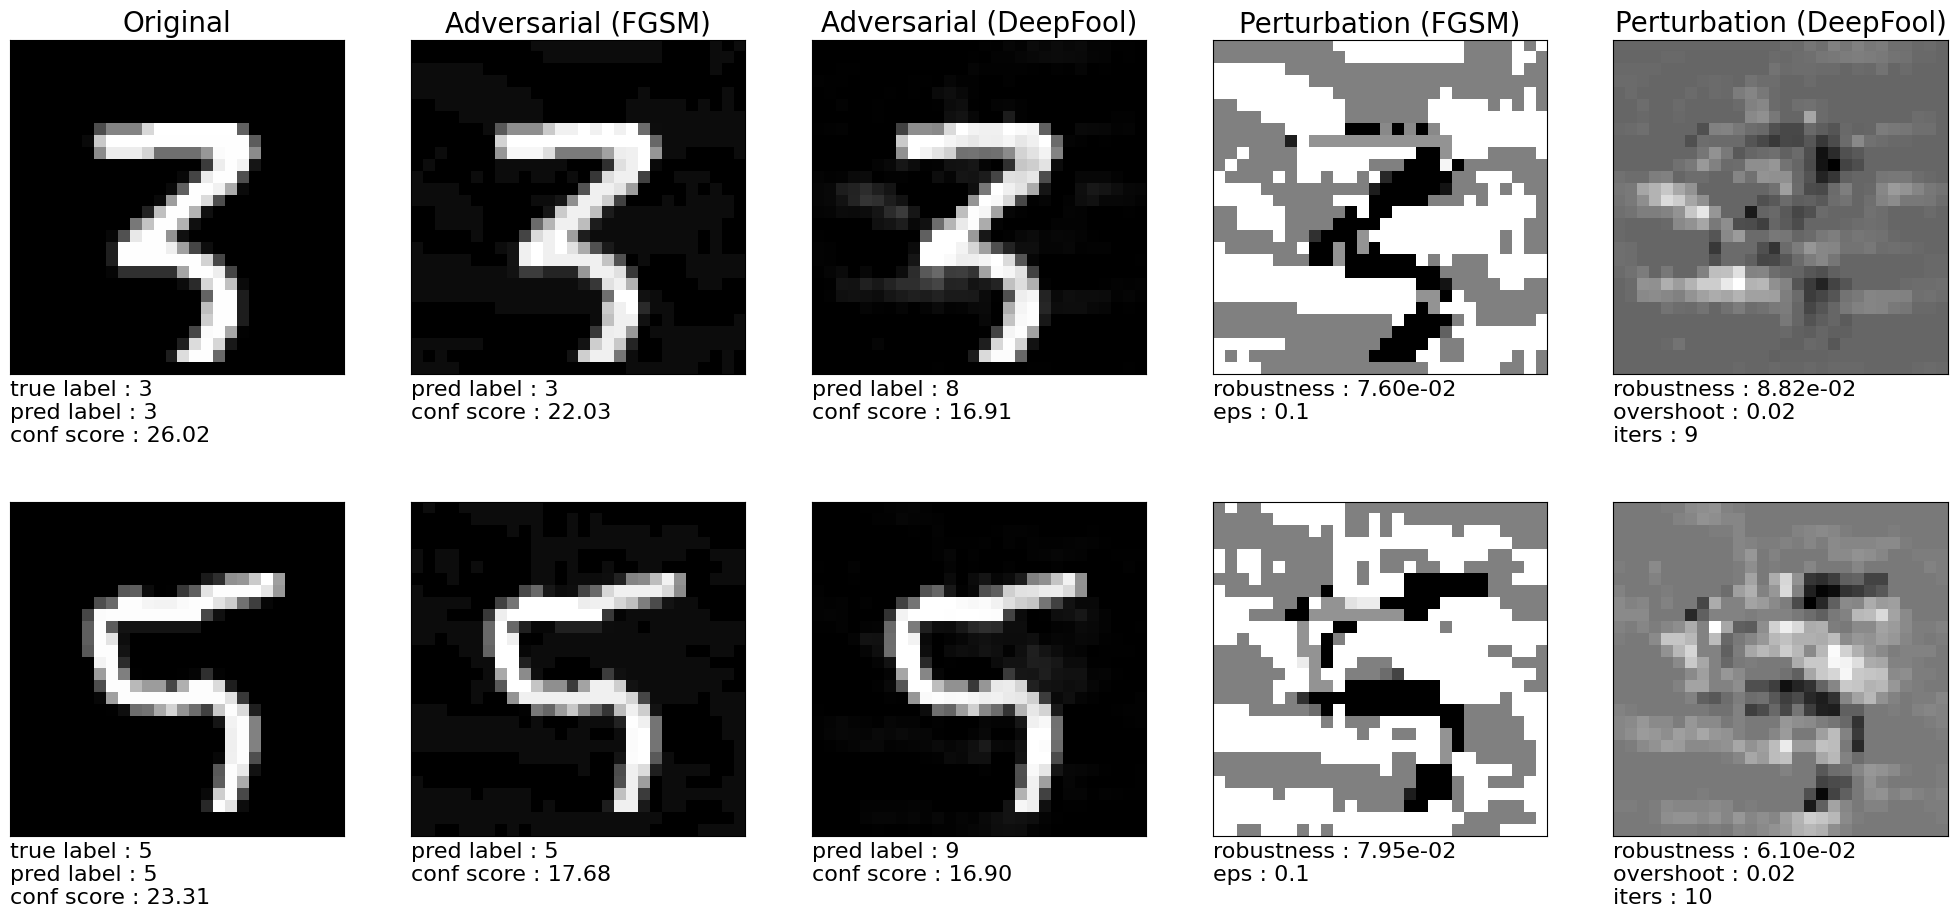

In [ ]:
fgsm_eps = 0.1
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### FC Model

<ipython-input-27-6ee960c5febf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


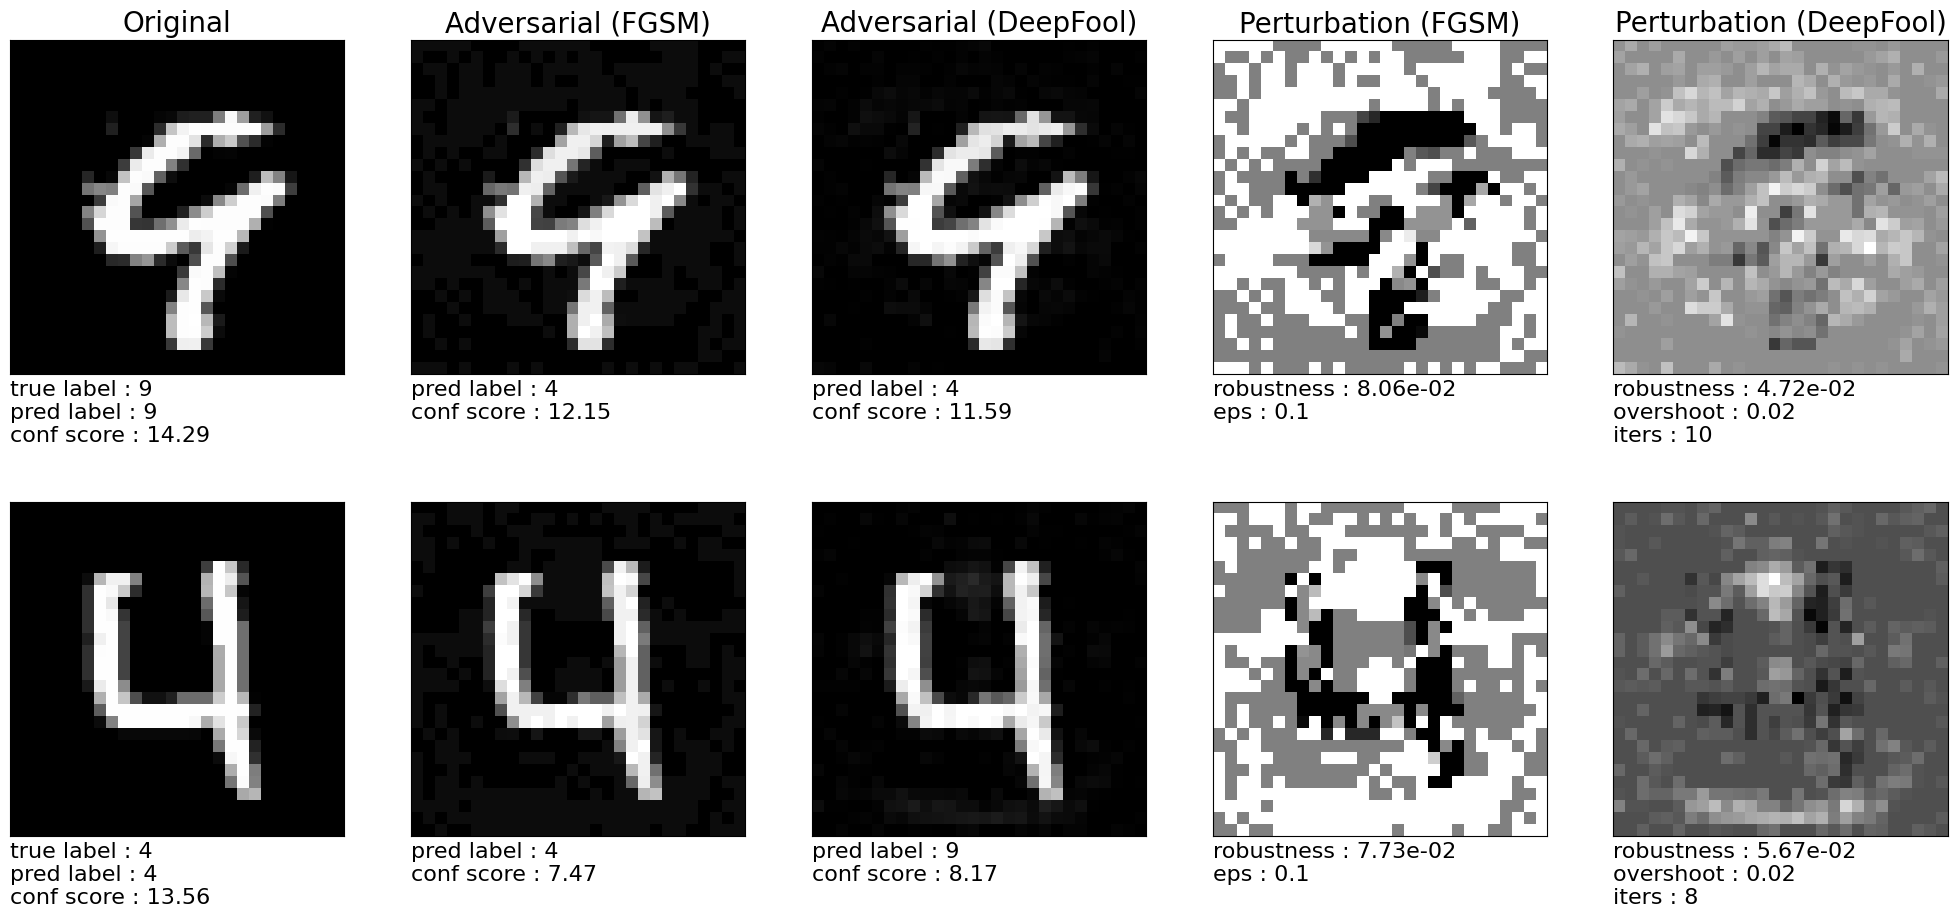

In [ ]:
fgsm_eps = 0.1
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### CIFAR-10

#### Network-In-Network Model

<ipython-input-28-142f639cd12a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


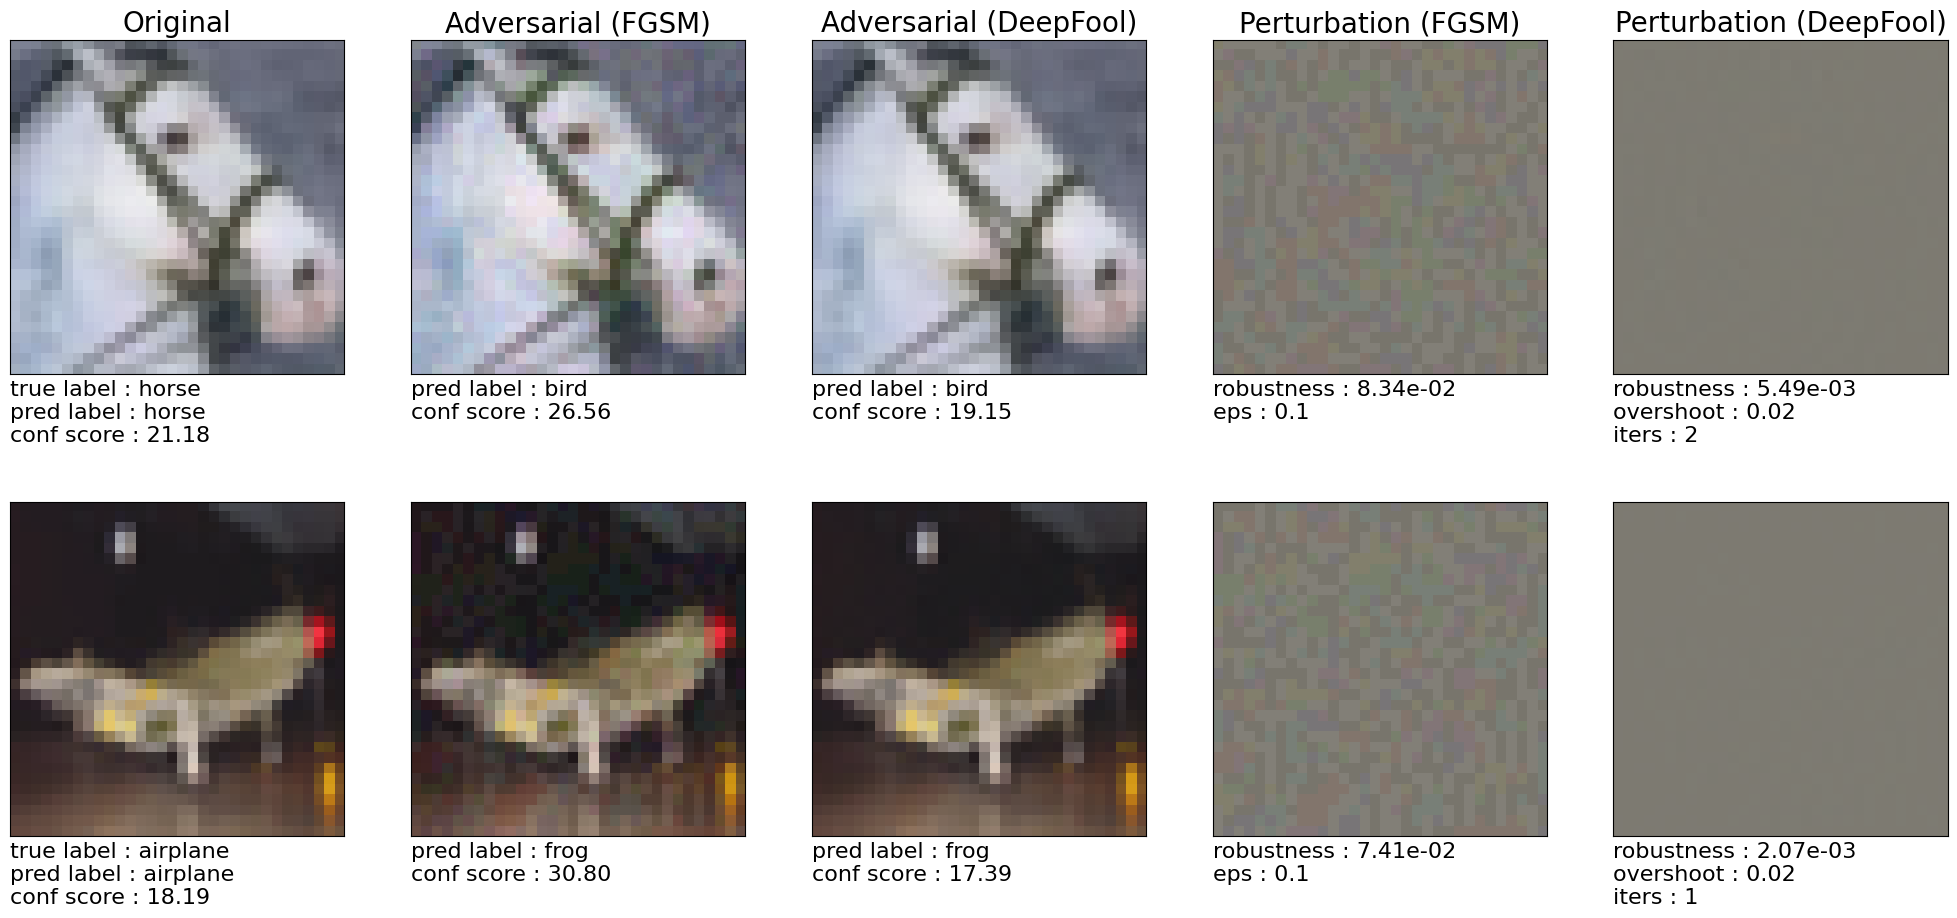

In [ ]:
fgsm_eps = 0.1
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### LeNet Model

<ipython-input-31-ce57b5d9ce5d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.10

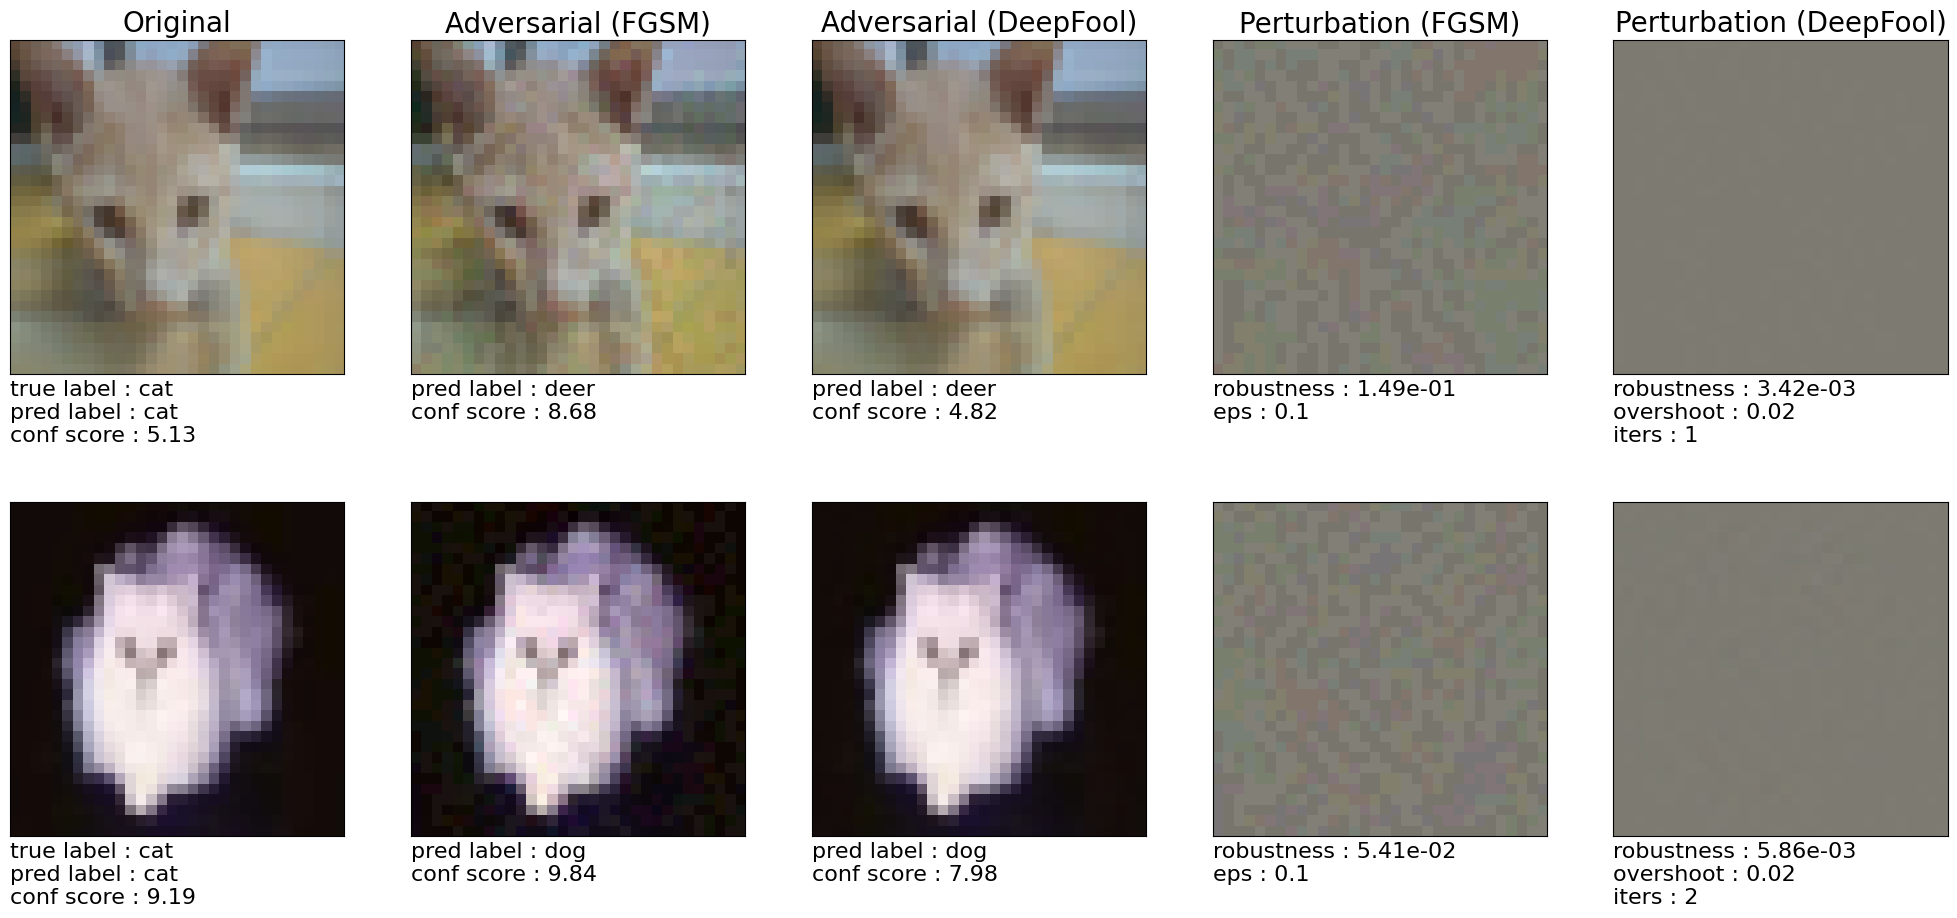

In [ ]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### ImageNet

#### GoogLeNet Model

In [ ]:
fgsm_eps = 0.02
model = models.googlenet(pretrained=True).to(device)

display_attack(device, model, imagenet_test, imagenet_tf_inv,
               imagenet_min, imagenet_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=5.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=imagenet_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 56.5MB/s]


NameError: name 'imagenet_test' is not defined